In [ ]:
!pip install tqdm

In [1]:
import pandas as pd
import numpy as np
import re

from tqdm import tqdm
from collections import defaultdict
from sklearn.utils.extmath import softmax
from matplotlib import pyplot as plt
from collections import Counter

%matplotlib inline

In [2]:
train_topic_vectors = np.load('topics_train_ngramm.npy')
test_topic_vectors = np.load('topics_test_ngramm.npy')

train_topic_vectors[train_topic_vectors < 0.0001] = 0
test_topic_vectors[test_topic_vectors < 0.0001] = 0

topics_count = train_topic_vectors.shape[1]
topics_count

355

In [3]:
train_df = pd.read_csv('data/train_data_complaints_repeats_doctors.csv').fillna('')
test_df = pd.read_csv('data/test_data_complaints_repeats_doctors.csv').fillna('')

In [65]:
active_topics = 250
topic_names = ['topic_{}'.format(i) for i in range(active_topics)]

train_df[topic_names] = pd.DataFrame(train_topic_vectors[:, :active_topics])
test_df[topic_names] = pd.DataFrame(train_topic_vectors[:, :active_topics])

In [66]:
freq_diagnoses = train_df.groupby(['Id_Пациента']).apply(lambda x: np.argmax(x.Код_диагноза.value_counts()))

In [67]:
MAX_AGE = 98

train_df.Возраст = np.maximum(train_df.Возраст.values, MAX_AGE)
test_df.Возраст = np.maximum(test_df.Возраст.values, MAX_AGE)

In [73]:
min_freq_threshold = 5
classes_count = (train_df.Код_диагноза.value_counts() > min_freq_threshold).sum() + 1
classes_count

767

In [74]:
classes = list((train_df.Код_диагноза.value_counts() > min_freq_threshold)[
    (train_df.Код_диагноза.value_counts() > min_freq_threshold)].keys())

In [75]:
class_to_idx = {c: i for i, c in enumerate(classes, start=1)}
idx_to_class = {i: c for i, c in enumerate(classes, start=1)}

In [76]:
def df2vw(features_extractor, df, out_filename, train=True):
    file = open(out_filename, 'w', encoding='utf8')
    for row in tqdm(df.iterrows()):
        features = features_extractor(row)
        if train:
            label = class_to_idx.get(row[1].Код_диагноза, len(class_to_idx) + 1)
        else:
            label = ''
        file.write('{} {}\n'.format(label, features))
    file.close()

In [77]:
def extract_ngram_body(row, ngram=3):
    body_text = row[1]['Жалобы']
    body_text = re.sub('[\|\:]', '䷀', body_text)
    body_text = re.sub('\n', '䷚', body_text)
    
    def compute_word_ngrams(counter, word, ngram):
        for index in range(1, len(word) - ngram + 1):
            counter[word[index:(index + ngram)]] += 1
            
    ngrams_dict = Counter()
    for word in body_text.split(' '):
        compute_word_ngrams(ngrams_dict, word, ngram)
        
    return ' '.join('{}:{}'.format(*item) for item in ngrams_dict.items())

In [78]:
def extract_words(row):
    return '|doctor ' + str(row[1].Врач) + ' ' + \
           '|clinic ' + str(row[1].Клиника) + ' ' + \
           '|gender ' + str(row[1].Пол) + ' ' + \
           '|age_feature:' + str(MAX_AGE) + ' age:' + str(row[1].Возраст) + ' ' + \
           '|topics ' + ' '.join(topic_name + ':' + str(row[1][topic_name])
                                  for topic_name in topic_names) + ' ' + \
           '|char_ngrams ' + extract_ngram_body(row) + ' ' + \
           '|complaint_ngram ' + str(row[1]['Жалобы (ngramm)']) + ' ' + \
           '|complaint_uni ' + str(row[1]['Жалобы (unigramm)'])

In [79]:
df2vw(extract_words, train_df, 'train.vw')

61976it [01:45, 586.51it/s]


In [80]:
df2vw(extract_words, test_df, 'test.vw', train=False)

30000it [00:50, 597.49it/s]


In [81]:
! rm cache_file.vw

In [82]:
! vw -d train.vw --loss_function logistic --oaa $classes_count -f model --threads -b 22 --passes 5 --cache_file cache_file.vw

final_regressor = model
Num weight bits = 22
learning rate = 0.5
initial_t = 0
power_t = 0.5
decay_learning_rate = 1
creating cache_file = cache_file.vw
Reading datafile = train.vw
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
1.000000 1.000000            1            1.0        9        1       48
1.000000 1.000000            2            2.0      156        9       32
1.000000 1.000000            4            4.0       15      156       43
1.000000 1.000000            8            8.0       13      156       22
1.000000 1.000000           16           16.0      126      767       50
0.937500 0.875000           32           32.0       16       26       61
0.937500 0.937500           64           64.0      191      767       16
0.898438 0.859375          128          128.0        1        1      100
0.890625 0.882812          256          256.0       45       13       84


In [83]:
! vw -i model -t test.vw -r pred.out --threads

only testing
raw predictions = pred.out
Num weight bits = 22
learning rate = 0.5
initial_t = 0
power_t = 0.5
using no cache
Reading datafile = test.vw
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
    n.a.     n.a.            1            1.0  unknown      767       61
    n.a.     n.a.            2            2.0  unknown      767       32
    n.a.     n.a.            4            4.0  unknown      767       22
    n.a.     n.a.            8            8.0  unknown      767       58
    n.a.     n.a.           16           16.0  unknown      767       21
    n.a.     n.a.           32           32.0  unknown      767       83
    n.a.     n.a.           64           64.0  unknown        1       91
    n.a.     n.a.          128          128.0  unknown      767       30
    n.a.     n.a.          256          256.0  unknown      767       38
    n.a.     n.a.          512

In [87]:
def vw2probs(pred_name):
    predictions = []
    with open(pred_name) as file:
        for line in file.readlines():
            pred = [float(token.split(':')[1]) for token in line.split()]
            predictions.append(softmax(np.array([pred]))[0].argmax() + 1) # Predictions are from 1 to classes_count
    return np.array(predictions)

In [88]:
result = vw2probs('pred.out')

In [90]:
nontrivial_diagnosis = (result != classes_count).sum()
nontrivial_diagnosis

4553

In [91]:
test_df['Код_диагноза'] = [idx_to_class.get(i, '') for i in result]

In [92]:
test_df['Код_диагноза'][test_df['Код_диагноза'] == ''] = test_df[test_df['Код_диагноза'] == '']\
                            .apply(lambda row: freq_diagnoses.get(row.Id_Пациента, 'J06.9'), axis=1)

/opt/miniconda/envs/deeplearn/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [93]:
test_df[['Id_Записи', 'Код_диагноза']].to_csv('./submission_vw.csv', index=False, encoding='utf8')

In [113]:
train_df.Жалобы[889:892].apply(print)

прежние, динамики в состоянии не отмечает
прежние, динамики в состоянии не отмечает
прежние, динамики в состоянии не отмечает


889    None
890    None
891    None
Name: Жалобы, dtype: object

In [126]:
train_df[train_df.Жалобы == 'прежние, динамики в состоянии не отмечает'].Врач.value_counts()

эндокринолог    965
Name: Врач, dtype: int64

In [129]:
test_df[test_df.Жалобы == 'прежние, динамики в состоянии не отмечает']

,Unnamed: 0,Id_Записи,Id_Пациента,Возраст,Жалобы,Источник_рекламы,Клиника,Пол,Услуга,Жалобы (ngramm),Жалобы (unigramm),Врач,Повторный приём
1,1,1,509296,27,"прежние, динамики в состоянии не отмечает",ДМС,3,2,"Прием врача-эндокринолога повторный, амбулаторный",,прежний динамика состояние отмечать,онколог,1
66,66,66,327321,32,"прежние, динамики в состоянии не отмечает",Другое,3,2,"Прием врача-эндокринолога повторный, амбулаторный",,прежний динамика состояние отмечать,невролог,1
106,106,106,485526,25,"прежние, динамики в состоянии не отмечает",Другое,3,2,"Прием врача-эндокринолога повторный, амбулаторный",,прежний динамика состояние отмечать,невролог,1
124,124,124,248346,56,"прежние, динамики в состоянии не отмечает",Другое,3,2,"Прием врача-эндокринолога повторный, амбулаторный",,прежний динамика состояние отмечать,дерматовенеролог,1
221,221,221,290542,43,"прежние, динамики в состоянии не отмечает",Другое,3,2,"Прием врача-эндокринолога повторный, амбулаторный",,прежний динамика состояние отмечать,оториноларинголог,1
284,284,284,299979,57,"прежние, динамики в состоянии не отмечает",Другое,3,2,"Прием врача-эндокринолога повторный, амбулаторный",,прежний динамика состояние отмечать,невролог,1
486,486,486,390882,28,"прежние, динамики в состоянии не отмечает",Другое,3,1,"Прием врача-эндокринолога повторный, амбулаторный",,прежний динамика состояние отмечать,невролог,1
500,500,500,228361,40,"прежние, динамики в состоянии не отмечает",Другое,3,1,"Прием врача-эндокринолога повторный, амбулаторный",,прежний динамика состояние отмечать,терапевт,1
548,548,548,240296,42,"прежние, динамики в состоянии не отмечает",Другое,3,2,"Прием врача-эндокринолога повторный, амбулаторный",,прежний динамика состояние отмечать,,0
631,631,631,255595,45,"прежние, динамики в состоянии не отмечает",Другое,3,1,"Прием врача-эндокринолога повторный, амбулаторный",,прежний динамика состояние отмечать,невролог,1


In [130]:
test_df[test_df.Id_Пациента == 277308]

,Unnamed: 0,Id_Записи,Id_Пациента,Возраст,Жалобы,Источник_рекламы,Клиника,Пол,Услуга,Жалобы (ngramm),Жалобы (unigramm),Врач,Повторный приём
899,899,899,277308,33,"прежние, динамики в состоянии не отмечает",Другое,3,2,"Прием врача-эндокринолога повторный, амбулаторный",,прежний динамика состояние отмечать,эндокринолог,1
14828,14828,14828,277308,33,на дискомфорт в обоих ушах,Другое,3,2,"Прием врача-оториноларинголога первичный, амб...",,дискомфорт ухо,дерматовенеролог,1
21751,21751,21751,277308,33,прежние,Другое,3,2,"Прием врача-невролога повторный, амбулаторный",,прежний,акушер гинеколог,1


In [131]:
train_df[train_df.Id_Пациента == 277308]

,Unnamed: 0,Id_Записи,Id_Пациента,Возраст,Диагноз,Жалобы,Источник_рекламы,Клиника,Код_диагноза,Пол,Услуга,Жалобы (ngramm),Жалобы (unigramm),Врач,Повторный приём
56705,56705,56705,277308,33,Цервикалгия,"на боли в шее, скованность в ней, боль при нак...",Другое,3,M54.2,2,"Прием врача-невролога первичный, амбулаторный",наклон_вперёд быстрый_утомляемость,боль шея скованность боль наклон вперёд тревож...,невролог,0


In [138]:
from itertools import islice

In [141]:
for k, v in islice(train_df.Жалобы.value_counts().items(), 100):
    print('{}  —  {}'.format(k, v))

Не изменились с момента первого приема  —  2699
на момент осмотра не предъявляет  —  1472
активно не предъявляет. Явка профилактическая по беременности.  —  1297
не изменились с момента первого приема  —  1186
прежние, динамики в состоянии не отмечает  —  965
прежние  —  883
активно не предъявляет  —  822
нет  —  662
На момент осмотра активно жалоб не предъявляет.  —  498
на момент осмотра нет  —  397
не предъявляет.  —  395
Не предъявляет  —  365
явка по результатам анализов  —  361
на периодические бели  —  360
подошла с результатами обследования  —  358
на момент осмотра жалоб не предъявляет  —  353
жалоб нет  —  349
Явка повторная по результатам анализов  —  323
на выделения из половых путей  —  287
не предъявляет  —  286
На момент осмотра активных жалоб не предъявляет.  —  279
На боли в молочных железах по циклу  —  274
на бели  —  267
на периодическое затруднение носового дыхания, скудное слизистое отделяемое из полости носа  —  262
новых нет  —  247
активных жалоб нет  —  234
Пр

In [142]:
for k, v in islice(test_df.Жалобы.value_counts().items(), 100):
    print('{}  —  {}'.format(k, v))

Не изменились с момента первого приема  —  1311
активно не предъявляет. Явка профилактическая по беременности.  —  711
на момент осмотра не предъявляет  —  702
не изменились с момента первого приема  —  620
прежние, динамики в состоянии не отмечает  —  488
прежние  —  445
активно не предъявляет  —  402
нет  —  350
На момент осмотра активно жалоб не предъявляет.  —  227
не предъявляет.  —  220
подошла с результатами обследования  —  195
Не предъявляет  —  184
на периодические бели  —  182
явка по результатам анализов  —  180
на момент осмотра жалоб не предъявляет  —  180
на момент осмотра нет  —  176
жалоб нет  —  170
на выделения из половых путей  —  157
На момент осмотра активных жалоб не предъявляет.  —  153
на бели  —  151
не предъявляет  —  149
Явка повторная по результатам анализов  —  144
На боли в молочных железах по циклу  —  129
на периодическое затруднение носового дыхания, скудное слизистое отделяемое из полости носа  —  126
Прежние  —  107
новых нет  —  107
подошел с резуль

In [155]:
test_df.Жалобы.value_counts().values[:500].sum()

13006

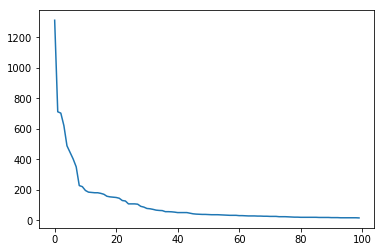

In [160]:
plt.plot(test_df.Жалобы.value_counts().values[:100])

In [162]:
test_df.Жалобы.value_counts().values.sum()

30000

In [163]:
test_df.Жалобы.value_counts().values[:40].sum()

8991

In [164]:
train_df[train_df.Жалобы == 'Не изменились с момента первого приема']

,Unnamed: 0,Id_Записи,Id_Пациента,Возраст,Диагноз,Жалобы,Источник_рекламы,Клиника,Код_диагноза,Пол,Услуга,Жалобы (ngramm),Жалобы (unigramm),Врач,Повторный приём
6,6,6,416352,29,Поражение межпозвоночных дисков других отделов,Не изменились с момента первого приема,Интернет,2,M51,2,"Прием врача-невролога повторный, амбулаторный",момент_первое_приём,измениться момент первое приём,невролог,1
15,15,15,213394,34,Остеохондроз позвоночника у взрослых,Не изменились с момента первого приема,Рекомендации знакомых,5,M42.1,2,"Прием врача-невролога повторный, амбулаторный",момент_первое_приём,измениться момент первое приём,невролог,1
26,26,26,507135,32,Поражение межпозвоночных дисков других отделов,Не изменились с момента первого приема,Интернет,2,M51,2,"Прием врача-невролога повторный, амбулаторный",момент_первое_приём,измениться момент первое приём,невролог,1
36,36,36,404662,17,Расстройства вегетативной [автономной] нервной...,Не изменились с момента первого приема,Интернет,5,G90,2,"Прием врача-невролога повторный, амбулаторный",момент_первое_приём,измениться момент первое приём,невролог,1
49,49,49,190113,47,Деформирующая дорсопатия неуточненная,Не изменились с момента первого приема,Другое,5,M43.9,2,"Прием врача-невролога повторный, амбулаторный",момент_первое_приём,измениться момент первое приём,невролог,1
56,56,56,132765,35,Остеохондроз позвоночника у взрослых,Не изменились с момента первого приема,Другое,5,M42.1,2,"Прием врача-невролога повторный, амбулаторный",момент_первое_приём,измениться момент первое приём,невролог,1
66,66,66,422330,42,Боль в конечности,Не изменились с момента первого приема,Интернет,2,M79.6,2,"Прием врача-невролога повторный, амбулаторный",момент_первое_приём,измениться момент первое приём,невролог,1
90,90,90,402383,60,Остеохондроз позвоночника у взрослых,Не изменились с момента первого приема,Рекомендации знакомых,5,M42.1,2,"Прием врача-невролога повторный, амбулаторный",момент_первое_приём,измениться момент первое приём,невролог,1
92,92,92,593440,59,Деформирующая дорсопатия неуточненная,Не изменились с момента первого приема,Интернет,5,M43.9,1,"Прием врача-невролога повторный, амбулаторный",момент_первое_приём,измениться момент первое приём,невролог,1
123,123,123,423516,63,Энцефалопатия неуточненная,Не изменились с момента первого приема,Рекомендации знакомых,5,G93.4,2,"Прием врача-невролога повторный, амбулаторный",момент_первое_приём,измениться момент первое приём,невролог,1


In [165]:
test_df[test_df.Жалобы == 'Не изменились с момента первого приема']

,Unnamed: 0,Id_Записи,Id_Пациента,Возраст,Жалобы,Источник_рекламы,Клиника,Пол,Услуга,Жалобы (ngramm),Жалобы (unigramm),Врач,Повторный приём
56,56,56,598740,72,Не изменились с момента первого приема,Рекомендации знакомых,5,2,"Прием врача-невролога повторный, амбулаторный",момент_первое_приём,измениться момент первое приём,невролог,1
97,97,97,160828,77,Не изменились с момента первого приема,Другое,5,2,"Прием врача-невролога повторный, амбулаторный",момент_первое_приём,измениться момент первое приём,гастроэнтеролог,0
138,138,138,546996,35,Не изменились с момента первого приема,Интернет,5,1,"Прием врача-невролога повторный, амбулаторный",момент_первое_приём,измениться момент первое приём,уролог,0
147,147,147,400438,41,Не изменились с момента первого приема,Другое,3,2,"Прием врача-невролога повторный, амбулаторный",момент_первое_приём,измениться момент первое приём,терапевт,0
152,152,152,477459,56,Не изменились с момента первого приема,Рекомендации знакомых,5,2,"Прием врача-невролога повторный, амбулаторный",момент_первое_приём,измениться момент первое приём,ортопед травматолог,1
269,269,269,584460,28,Не изменились с момента первого приема,Интернет,5,1,"Прием врача-невролога повторный, амбулаторный",момент_первое_приём,измениться момент первое приём,хирург,0
311,311,311,412748,27,Не изменились с момента первого приема,Рекомендации знакомых,2,2,"Прием врача-невролога повторный, амбулаторный",момент_первое_приём,измениться момент первое приём,невролог,1
312,312,312,548752,40,Не изменились с момента первого приема,Рекомендации знакомых,5,2,"Прием врача-невролога повторный, амбулаторный",момент_первое_приём,измениться момент первое приём,невролог,1
317,317,317,441804,27,Не изменились с момента первого приема,Зарегистрировался на сайте,2,1,"Прием врача-невролога повторный, амбулаторный",момент_первое_приём,измениться момент первое приём,ортопед травматолог,0
343,343,343,451948,48,Не изменились с момента первого приема,Рекомендации знакомых,2,2,"Прием врача-невролога повторный, амбулаторный",момент_первое_приём,измениться момент первое приём,акушер гинеколог,0


In [173]:
test_df.Услуга.str.contains('повторный').sum()

19562

In [174]:
train_df.Услуга.str.contains('повторный').sum()

40391

In [175]:
train_df.shape

(61976, 15)

In [186]:
test_df[test_df.Услуга.str.contains('повторный')].Жалобы.value_counts()

Не изменились с момента первого приема                                                                                                                                                                                       1305
на момент осмотра не предъявляет                                                                                                                                                                                              634
не изменились с момента первого приема                                                                                                                                                                                        584
прежние, динамики в состоянии не отмечает                                                                                                                                                                                     486
прежние                                                                                         

In [188]:
test_df[test_df.Жалобы == 'подошел с результатами обследования']

,Unnamed: 0,Id_Записи,Id_Пациента,Возраст,Жалобы,Источник_рекламы,Клиника,Пол,Услуга,Жалобы (ngramm),Жалобы (unigramm),Врач,Повторный приём
96,96,96,245210,30,подошел с результатами обследования,Другое,6,1,"Прием врача-гастроэнтеролога повторный, амбул...",результат_обследование,подойти результат обследование,оториноларинголог,0
365,365,365,377461,62,подошел с результатами обследования,Интернет,6,1,"Прием врача-гастроэнтеролога повторный, амбул...",результат_обследование,подойти результат обследование,дерматовенеролог,0
564,564,564,479272,25,подошел с результатами обследования,Рекомендации знакомых,6,1,"Прием врача-гастроэнтеролога повторный, амбул...",результат_обследование,подойти результат обследование,эндокринолог,0
1029,1029,1029,392297,33,подошел с результатами обследования,Интернет,6,1,"Прием врача-гастроэнтеролога повторный, амбул...",результат_обследование,подойти результат обследование,невролог,1
1411,1411,1411,395711,41,подошел с результатами обследования,Интернет,6,1,"Прием врача-гастроэнтеролога повторный, амбул...",результат_обследование,подойти результат обследование,хирург,1
1550,1550,1550,173690,59,подошел с результатами обследования,Другое,6,1,"Прием врача-гастроэнтеролога повторный, амбул...",результат_обследование,подойти результат обследование,,0
2189,2189,2189,451122,32,подошел с результатами обследования,Интернет,6,1,"Прием врача-гастроэнтеролога повторный, амбул...",результат_обследование,подойти результат обследование,невролог,1
2310,2310,2310,557544,36,подошел с результатами обследования,Интернет,6,1,"Прием врача-гастроэнтеролога повторный, амбул...",результат_обследование,подойти результат обследование,ортопед травматолог,0
2415,2415,2415,584502,26,подошел с результатами обследования,Интернет,6,1,"Прием врача-гастроэнтеролога повторный, амбул...",результат_обследование,подойти результат обследование,оториноларинголог,0
2641,2641,2641,186661,53,подошел с результатами обследования,Другое,6,1,"Прием врача-гастроэнтеролога повторный, амбул...",результат_обследование,подойти результат обследование,невролог,1


In [195]:
train_df[train_df.Жалобы == 'прежние'].Пол.value_counts()

2    549
1    334
Name: Пол, dtype: int64

In [196]:
train_df[(train_df.Жалобы == 'прежние') & (train_df.Пол == 1)]

,Unnamed: 0,Id_Записи,Id_Пациента,Возраст,Диагноз,Жалобы,Источник_рекламы,Клиника,Код_диагноза,Пол,Услуга,Жалобы (ngramm),Жалобы (unigramm),Врач,Повторный приём
91,91,91,458160,36,Хронический тонзиллит,прежние,Интернет,6,J35.0,1,"Прием врача-оториноларинголога повторный, амбу...",,прежний,оториноларинголог,1
344,344,344,398775,63,Фибрилляция и трепетание предсердий,прежние,Другое,3,I48,1,"Прием врача-кардиолога повторный, амбулаторный",,прежний,кардиолог,1
384,384,384,257495,68,Гиперплазия предстательной железы,прежние,Другое,3,N40,1,"Прием врача-уролога повторный, амбулаторный",,прежний,уролог,1
579,579,579,405389,50,Серная пробка,прежние,Интернет,6,H61.2,1,"Прием врача-оториноларинголога повторный, амбу...",,прежний,оториноларинголог,1
783,783,783,600612,30,Микоз кистей,прежние,ДМС,3,B35.2,1,"Прием врача-дерматовенеролога повторный, амбу...",,прежний,дерматовенеролог,1
850,850,850,426162,27,Другие гастриты,прежние,Рекомендации знакомых,6,K29.6,1,"Прием врача-колопроктолога повторный, амбулат...",,прежний,колопроктолог,1
972,972,972,416871,37,"Абсцесс кожи, фурункул и карбункул лица",прежние,Рекомендации знакомых,3,L02.0,1,"Прием врача-дерматовенеролога повторный, амбу...",,прежний,дерматовенеролог,1
1001,1001,1001,120794,59,Боль внизу спины,прежние,Интернет,2,M54.5,1,Повторный прием невролога,,прежний,невролог,0
1461,1461,1461,426060,64,Цервикалгия,прежние,Листовки,5,M54.2,1,"Прием врача-невролога повторный, амбулаторный",,прежний,невролог,1
1464,1464,1464,419288,55,Вазомоторный и аллергический ринит,прежние,Рекомендации знакомых,6,J30,1,"Прием врача-оториноларинголога повторный, амбу...",,прежний,оториноларинголог,1


In [197]:
test_df[test_df.Id_Пациента == 252956]

,Unnamed: 0,Id_Записи,Id_Пациента,Возраст,Жалобы,Источник_рекламы,Клиника,Пол,Услуга,Жалобы (ngramm),Жалобы (unigramm),Врач,Повторный приём
11123,11123,11123,252956,59,На сохраняющиеся высыпания на коже стоп,Другое,3,1,"Прием врача-дерматовенеролога повторный, амбу...",сохраняться_высыпание кожа_стоп,сохраняться высыпание кожа стоп,,0
23975,23975,23975,252956,59,затуманивание и выраженная расфокусировка зрения.,Другое,3,1,"Прием врача-офтальмолога первичный, амбулаторный",расфокусировка_зрение,затуманивание выразить расфокусировка зрение,невролог,1


In [198]:
train_df[train_df.Id_Пациента == 252956]

,Unnamed: 0,Id_Записи,Id_Пациента,Возраст,Диагноз,Жалобы,Источник_рекламы,Клиника,Код_диагноза,Пол,Услуга,Жалобы (ngramm),Жалобы (unigramm),Врач,Повторный приём
6605,6605,6605,252956,59,Радикулопатия,боли шейном отделе позвоночника с иррадиацией...,Другое,3,M54.1,1,"Прием врача-невролога повторный, амбулаторный",шейный_отдел_позвоночник левый_рука левый_рука,боль шейный отдел позвоночник иррадиация левый...,невролог,1
10800,10800,10800,252956,59,Гиперметропия,на снижение зрения вдаль и вблизи,Другое,3,H52.0,1,"Прием врача-офтальмолога первичный, амбулаторный",снижение_зрение_вдаль,снижение зрение вдаль вблизи,офтальмолог,0
38303,38303,38303,252956,59,"Инфекции, вызванные вирусом герпеса [herpes si...",На сохраняющиеся высыпания на коже верхней губ...,Другое,3,B00,1,"Прием врача-дерматовенеролога повторный, амбу...",сохраняться_высыпание кожа_верхний_губа появле...,сохраняться высыпание кожа верхний губа появле...,дерматовенеролог,1
42342,42342,42342,252956,59,Астигматизм,"снижение зрения вдаль, вблизи, пелена, затума...",Другое,3,H52.2,1,"Прием врача-офтальмолога первичный, амбулаторный",снижение_зрение_вдаль расфокусировка_зрение,снижение зрение вдаль вблизи пелена затуманива...,офтальмолог,0
57696,57696,57696,252956,59,Радикулопатия,сохраняютя боли шейном отделе позвоночника с ...,Другое,3,M54.1,1,"Прием врача-невролога повторный, амбулаторный",шейный_отдел_позвоночник левый_рука левый_рука,сохраняютить боль шейный отдел позвоночник ирр...,невролог,1
60266,60266,60266,252956,59,Подозрение на глаукому,прежние,Другое,3,H40.0,1,"Прием врача-офтальмолога повторный, амбулаторный",,прежний,офтальмолог,1


In [223]:
train_df.Врач.value_counts()

невролог                     11602
акушер гинеколог             11242
терапевт                      6291
оториноларинголог             4794
гастроэнтеролог               4208
дерматовенеролог              4136
уролог                        3711
ортопед травматолог           2808
эндокринолог                  2487
кардиолог                     2459
офтальмолог                   2154
хирург                        2113
                              1043
онколог                        979
аллерголог иммунолог           513
ревматолог                     388
рефлексотерапевт терапевт      246
нейрохирург хирург             194
колопроктолог                  129
пульмонолог                    121
педиатр                        106
невролог травматолог            92
психотерапевт терапевт          74
реабилитолог ревматолог         52
стоматолог                      22
ортопед                          5
гинеколог                        4
ангиохирург хирург               3
Name: Врач, dtype: i

In [249]:
train_df[train_df.Услуга.str.contains('невролог')]

,Unnamed: 0,Id_Записи,Id_Пациента,Возраст,Диагноз,Жалобы,Источник_рекламы,Клиника,Код_диагноза,Пол,Услуга,Жалобы (ngramm),Жалобы (unigramm),Врач,Повторный приём
3,3,3,257197,55,Другая дорсалгия,"на сохраняющиеся боли в спине и пояснице, сков...",Другое,3,M54.8,1,"Прием врача-невролога повторный, амбулаторный",сохраняться_боль,сохраняться боль спина поясница скованность,невролог,1
6,6,6,416352,29,Поражение межпозвоночных дисков других отделов,Не изменились с момента первого приема,Интернет,2,M51,2,"Прием врача-невролога повторный, амбулаторный",момент_первое_приём,измениться момент первое приём,невролог,1
10,10,10,192103,22,Дорсопатия неуточненная,не изменились с момента первого приема,Другое,5,M53.9,2,"Прием врача-невролога повторный, амбулаторный",момент_первое_приём,измениться момент первое приём,невролог,1
15,15,15,213394,34,Остеохондроз позвоночника у взрослых,Не изменились с момента первого приема,Рекомендации знакомых,5,M42.1,2,"Прием врача-невролога повторный, амбулаторный",момент_первое_приём,измениться момент первое приём,невролог,1
24,24,24,478901,41,Остеохондроз позвоночника у взрослых,На боль в поясничном отделе позвоночника по ВА...,Рекомендации знакомых,5,M42.1,1,"Прием врача-невролога повторный, амбулаторный",поясничный_отдел_позвоночник,боль поясничный отдел позвоночник балл иррадиация,невролог,1
25,25,25,631320,57,Другие уточненные дорсопатии,"на боли в шеи, грудном отделе позвоночника до ...",Живет-работает рядом,5,M53.8,2,"Прием врача-невролога первичный, амбулаторный",грудной_отдел_позвоночник периодически_возника...,боль шея грудной отдел позвоночник балл период...,невролог,0
26,26,26,507135,32,Поражение межпозвоночных дисков других отделов,Не изменились с момента первого приема,Интернет,2,M51,2,"Прием врача-невролога повторный, амбулаторный",момент_первое_приём,измениться момент первое приём,невролог,1
34,34,34,617589,45,Боль внизу спины,Жалобы прежние. Отмечает некоторое улучшение с...,Интернет,19,M54.5,2,"Прием врача-невролога повторный, амбулаторный",жалоба_прежний отмечать_некоторый_улучшение_са...,жалоба прежний отмечать некоторый улучшение са...,невролог,1
36,36,36,404662,17,Расстройства вегетативной [автономной] нервной...,Не изменились с момента первого приема,Интернет,5,G90,2,"Прием врача-невролога повторный, амбулаторный",момент_первое_приём,измениться момент первое приём,невролог,1
49,49,49,190113,47,Деформирующая дорсопатия неуточненная,Не изменились с момента первого приема,Другое,5,M43.9,2,"Прием врача-невролога повторный, амбулаторный",момент_первое_приём,измениться момент первое приём,невролог,1


In [251]:
train_df[train_df.Услуга.str.contains('гинеколог')].Код_диагноза.value_counts()

N76.0     1936
Z32.1     1132
N77.1*     954
N76.1      613
Z34.0      571
Z01.4      518
N72        444
D25        382
B37.3+     358
N86        358
Z34.8      291
N84.0      256
Z35.8      248
N83.0      248
E28        238
N80.0      191
Z00.0      168
Z01        135
N95.2      127
Z00        103
N83.2       98
Z34         85
N85.0       83
B37         80
Z01.7       80
B97.7       71
N70         64
N88.0       58
N95.1       56
E28.9       50
          ... 
O34.2        1
N91.2        1
Z35.2        1
O04.9        1
R32          1
O99.4        1
N30          1
A56.0        1
Y83.4        1
O31.2        1
Z08          1
N93.8        1
D20.0        1
O03.4        1
O04.0        1
O04.4        1
O26.4        1
Z09.0        1
O82.0        1
N94.4        1
B00.8        1
N81.5        1
Z00.8        1
O26.2        1
E29.9        1
O26.9        1
O92          1
N96          1
N60.2        1
O08.9        1
Name: Код_диагноза, Length: 245, dtype: int64

In [214]:
test_df[test_df.Услуга.str.contains('терапевт')].shape

(3233, 13)

In [215]:
test_df[test_df.Услуга.str.contains('оториноларинголог')].shape

(2360, 13)

In [216]:
test_df[test_df.Услуга.str.contains('гастроэнтеролог')].shape

(2064, 13)

In [217]:
test_df[test_df.Услуга.str.contains('дерматовенеролог')].shape

(1998, 13)

In [218]:
test_df[test_df.Услуга.str.contains('уролог')].shape

(1861, 13)

In [219]:
test_df[test_df.Услуга.str.contains('ортопед')].shape

(1217, 13)

In [220]:
test_df[test_df.Услуга.str.contains('эндокринолог')].shape

(1183, 13)

In [275]:
for k, v in islice(pd.Series(' '.join(train_df['Жалобы (ngramm)']).split()).value_counts().items(), 100):
    print('{} — {}'.format(k, v))

явка_профилактический — 577
момент_осмотр_жалоба — 118
момент_осмотр — 111
задержка_менструация — 31
половый_путь — 30
задержка_месячный — 23
тянущий_боль — 20
периодический_тянущий_боль — 17
ведение_беременность — 12
задержка_мц — 11
заложенность_нос — 11
результат_анализ — 9
периодический_затруднение_носовой_дыхание — 8
общий_слабость — 7
момент_осмотр_активный_жалоба — 6
профилактический_осмотр — 6
результат_обследование — 6
мазать_выделение — 6
беременность_положительный — 6
полость_нос — 5
ноющий_боль — 5
пролонгирование_беременность — 5
кровянистый_выделение — 4
явка_повторный — 4
слизистый_отделять — 4
фон_проводить_терапия — 4
тест_положительный — 3
слизистый_насморк — 3
сукровичный_выделение — 3
дать_беременность — 3
периодический_боль — 3
коричневый_выделение — 3
нарушение_менструальный_цикл — 3
активный_жалоба — 3
скудный_сукровичный_выделение — 2
периодический_головокружение — 2
периодический_тошнота — 2
эпигастральный_область — 2
вздутие_живот — 2
место_жительство — 2
седа

In [237]:
train_df[train_df['Жалобы (ngramm)'].str.contains('общий_слабость')].Код_диагноза.value_counts()

J06.9    670
J00      209
J18      146
E03.8     67
J04.1     57
D50.9     47
B00       44
G90       37
D50       37
J20.9     34
E06.3     27
J03.9     22
Z00.0     21
J18.9     20
E04.2     19
E11       18
E03.9     17
E04.1     17
E89.0     15
J06       15
Z01.8     14
D50.0     13
J02.9     11
J20       11
I11.9     11
E01.8     10
S06.0     10
I11        9
I67.8      9
D64.9      8
        ... 
D72.1      1
N84.0      1
I22.0      1
G20        1
R07.4      1
G24.9      1
B34.8      1
E61.1      1
E21.3      1
K52        1
I20        1
I49.8      1
K73.9      1
L30.8      1
R00.2      1
O24.1      1
M54.8      1
N28.1      1
J01.9      1
B01.9      1
I50.0      1
Z00.8      1
M45        1
J42        1
J32.0      1
E22.1      1
K70        1
B00.1      1
E07        1
N80.0      1
Name: Код_диагноза, Length: 195, dtype: int64

In [253]:
train_df.Код_диагноза.value_counts()

J06.9     2147
M42.1     1949
N76.0     1942
J00       1379
Z32.1     1358
N41.1     1111
Z00.0     1048
N77.1*     956
I11        956
K30        779
J35.0      776
M54.2      713
N60.1      657
N76.1      617
M54.8      605
M54.5      579
Z34.0      571
M65        570
K29.9      562
M42        531
M53.8      528
Z01.4      518
M51        480
Z01.8      477
H52.1      474
K29.5      472
D23.9      471
M54.4      470
N72        445
G90        433
          ... 
N80.5        1
L60.9        1
M20.3        1
D72.9        1
S83.0        1
C43.7        1
H36.0*       1
O30.0        1
F51.3        1
I09.8        1
N32.9        1
G30.8        1
G96.8        1
F43.1        1
T80.2        1
B34.8        1
E07.9        1
E23.6        1
S32.3        1
C67.2        1
C18.4        1
Z27          1
K56.6        1
I71.2        1
I80.9        1
M77.2        1
R09.1        1
D14.3        1
F48.8        1
I72.9        1
Name: Код_диагноза, Length: 2302, dtype: int64

In [319]:
train_df[train_df.Услуга == 'Первичный прием невролога'].Диагноз.value_counts()

Остеохондроз позвоночника у взрослых                                             4
Сколиоз                                                                          1
Боль внизу спины                                                                 1
Внутримозговое кровоизлияние в полушарие субкортикальное                         1
Люмбаго с ишиасом                                                                1
Поражения межпозвоночных дисков поясничного и других отделов с радикулопатией    1
Поражение межпозвоночных дисков других отделов                                   1
Цервикалгия                                                                      1
Name: Диагноз, dtype: int64

In [308]:
train_df.Услуга.value_counts().keys()[:100]

Index(['Прием врача-невролога  повторный, амбулаторный',
       'Прием врача-акушера-гинеколога повторный, амбулаторный',
       'Прием врача-терапевта  повторный, амбулаторный',
       'Прием врача-гастроэнтеролога  повторный, амбулаторный',
       'Прием врача-уролога повторный, амбулаторный',
       'Прием врача-оториноларинголога  первичный, амбулаторный',
       'Прием врача-терапевта  первичный, амбулаторный',
       'Прием врача-оториноларинголога повторный, амбулаторный',
       'Прием врача-дерматовенеролога  повторный, амбулаторный',
       'Прием врача-дерматовенеролога  первичный, амбулаторный',
       'Прием врача-травматолога-ортопеда повторный, амбулаторный',
       'Прием врача-акушера-гинеколога беременной',
       'Прием врача-невролога  первичный, амбулаторный',
       'Прием врача-эндокринолога повторный, амбулаторный',
       'Прием врача-кардиолога  повторный, амбулаторный',
       'Прием врача-офтальмолога  первичный, амбулаторный',
       'Прием врача-акушера-ги

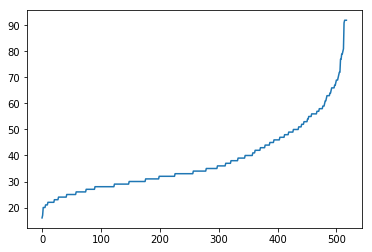

In [301]:
plt.plot(sorted(train_df[(train_df.Код_диагноза == 'Z01.4')].Возраст))

In [7]:
from sklearn.feature_extraction.text import HashingVectorizer

In [8]:
diagnoses_concat = train_df.groupby('Id_Пациента').apply(lambda group: ' '.join(group.Код_диагноза.values))

vectorizer = HashingVectorizer(n_features=30)
diagnoses_hashed = vectorizer.fit_transform(diagnoses_concat)

In [9]:
history = pd.DataFrame(data={
    'Id_Пациента': diagnoses_concat.index
})

features = ['history_{}'.format(i) for i in range(30)]
history[features] = pd.DataFrame(diagnoses_hashed.toarray())

In [23]:
test_merged = pd.merge(test_df, history, how='left')
test_merged[features] = test_merged[features].fillna(0.0)